In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-08-19 22:02:54 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-08-19 22:02:55 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-08-19 22:02:55 __main__ INFO     transformers.__version__='4.54.1'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-08-19 22:02:58 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-19 22:02:58 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-19 22:02:58 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-08-19 22:02:58 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-08-19 22:02:59 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-08-19 22:02:59 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-08-19 22:02:59 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-08-19 22:02:59 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-08-19 22:02:59 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-08-19 22:03:49 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-08-19 22:03:49 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-08-19 22:03:49 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
# file_path = os.path.join(
#     env_utils.DEFAULT_DATA_DIR,
#     "selection",
#     # "profession.json"
#     # "nationality.json"
#     "objects.json",
# )

# with open(file_path, "r") as f:
#     temp = json.load(f)

# for cat in temp["categories"]:
#     temp["categories"][cat] = [obj.capitalize() for obj in temp["categories"][cat]]

# with open(file_path, "w") as f:
#     json.dump(temp, f, indent=4)


In [6]:
from src.selection.data import SelectOneTask, SelectOrderTask

#################################################################################
# TASK_CLS = SelectOrderTask
# prompt_template_idx = 1
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

select_task.filter_single_token(mt.tokenizer, prefix=" ")
print(select_task)

SelectOneTask: (different objects)
Categories: fruit(11), vehicle(8), furniture(8), animal(13), music instrument(3), clothing(11), electronics(11), sport equipment(5), kitchen appliance(4), vegetable(5), building(14), office supply(8), bathroom item(7), flower(6), tree(10), jewelry(7)



In [7]:
sample = select_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    obj_idx=2,
    # category="actor",
    # category="Brazil"
    category="fruit",
    filter_by_lm_prediction=False,
)

print(sample)
print(sample.prompt())

Mango -> Raspberry (2): ['Suit', 'Ring', 'Raspberry', 'Eagle', 'Tomato', 'Chair']
Options: Suit, Ring, Raspberry, Eagle, Tomato, Chair.
Which among these objects mentioned above is a fruit?
Answer:


In [8]:
from src.selection.utils import verify_correct_option
# sample.prompt_template = select_prof.prompt_templates[3]
print(f'"{sample.prompt()}"', ">>", sample.obj)

verify_correct_option(
    mt=mt,
    target=sample.obj,
    options=sample.options,
    input=sample.prompt()
)

"Options: Suit, Ring, Raspberry, Eagle, Tomato, Chair.
Which among these objects mentioned above is a fruit?
Answer:" >> Raspberry


(True,
 [PredictedToken(token=' Raspberry', prob=0.7109375, logit=20.75, token_id=48665, metadata=None),
  PredictedToken(token=' Among', prob=0.0849609375, logit=18.625, token_id=22395, metadata=None),
  PredictedToken(token=' The', prob=0.0751953125, logit=18.5, token_id=578, metadata=None),
  PredictedToken(token=' Tomato', prob=0.0167236328125, logit=17.0, token_id=94091, metadata=None),
  PredictedToken(token=' A', prob=0.0167236328125, logit=17.0, token_id=362, metadata=None)],
 OrderedDict([(48665,
               (1,
                PredictedToken(token=' Raspberry', prob=0.7109375, logit=20.75, token_id=48665, metadata=None))),
              (94091,
               (5,
                PredictedToken(token=' Tomato', prob=0.0167236328125, logit=17.0, token_id=94091, metadata=None))),
              (33711,
               (16,
                PredictedToken(token=' Suit', prob=0.002410888671875, logit=15.0625, token_id=33711, metadata=None))),
              (22249,
               (

In [9]:
from src.functional import generate_with_patch

gen = generate_with_patch(
    mt = mt,
    inputs = sample.prompt(),
    max_new_tokens=20,
    do_sample=False,
    remove_prefix=True
)[0]
print(f'"{gen}"', ">>", sample.obj)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


" Raspberry.
Explanation: Raspberry is a fruit. The other options are not fruits. Suit is a type" >> Raspberry


In [10]:
mt.n_layer, mt.config.num_attention_heads

(80, 64)

In [11]:
HEADS = [
    (33, 45),
    (33, 18),
    (34, 1),
    (34, 6),
    (34, 7),
    (35, 19),
    (39, 40),
    (42, 30),
    (47, 18),
    (52, 58),
]
# HEADS = [(35, 19)]


# with open("optimized_heads.json", "r") as f:
#     HEADS = json.load(f)

# with open("category_wise_heads.json", "r") as f:
#     category_wise_heads = json.load(f)
# HEADS = [
#     (layer_idx, head_idx)
#     for layer_idx, head_idx, score in category_wise_heads["all"][:100]
# ]
# HEADS = [(layer_idx, head_idx) for layer_idx, head_idx in HEADS if layer_idx < 61]


print(len(HEADS))

10


2025-08-19 22:04:46 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data
2025-08-19 22:04:46 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib
2025-08-19 22:04:46 matplotlib DEBUG    interactive is False
2025-08-19 22:04:46 matplotlib DEBUG    platform is linux
2025-08-19 22:04:46 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-08-19 22:04:46 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json
2025-08-19 22:04:47 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-19 22:04:47 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-19 22:04:47 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-08-19 22:04:47 matplotlib.font

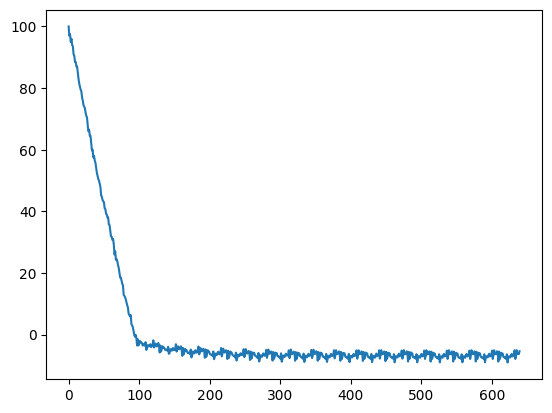

In [12]:
from matplotlib import pyplot as plt
import numpy as np

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    mt.name.split("/")[-1],
    f"{select_task.task_name}.npz"
)

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

66


(True, True)

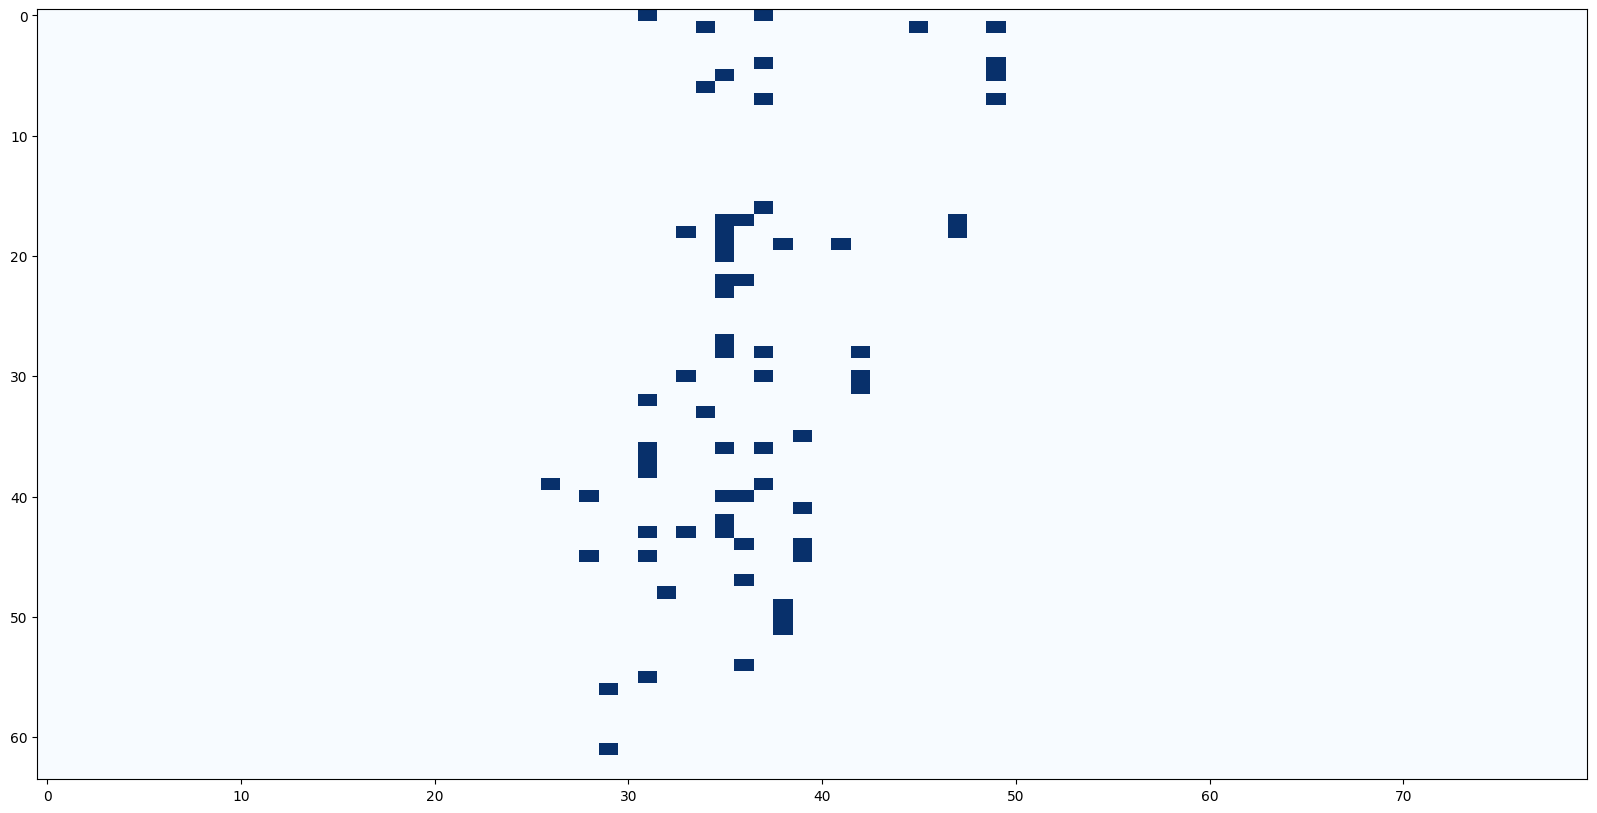

In [13]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[50:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

heads_selected = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
heads_selected = [
    (layer_idx, head_idx) for layer_idx, head_idx in heads_selected if layer_idx < 50
]
print(len(heads_selected))

HEADS = heads_selected

(35, 19) in HEADS, (35, 19) in heads_selected

In [14]:
from src.attention import get_attention_matrices
from src.selection.functional import (
    verify_head_patterns,
    get_patches_to_verify_independent_enrichment,
)

attn_pattern = verify_head_patterns(
    prompt=sample.prompt(option_style="single_line"),
    options=sample.options,
    pivot=sample.subj,
    mt=mt,
    heads=HEADS,
)

0 patches to ablate possible answer information from options
2025-08-19 22:04:55 src.selection.functional DEBUG    Predictions: ['" Raspberry"[48665] (p=0.711, logit=20.750)', '" Among"[22395] (p=0.085, logit=18.625)', '" The"[578] (p=0.075, logit=18.500)', '" Tomato"[94091] (p=0.017, logit=17.000)', '" A"[362] (p=0.017, logit=17.000)']
2025-08-19 22:04:55 src.selection.functional INFO     Combined attention matrix for all heads


In [15]:
import copy
import random
from src.selection.utils import KeyedSet, get_first_token_id, verify_correct_option
from src.selection.data import SelectionSample
from src.functional import predict_next_token
from src.tokens import prepare_input

######################################################################
N_DISTRACTORS = 5
WINDOW_SPEC = {
    mt.layer_name_format: 1,
    mt.mlp_module_name_format: 9,
    mt.attn_module_name_format: 9,
}
module_name_format = mt.layer_name_format
# module_name_format = mt.mlp_module_name_format
# module_name_format = mt.attn_module_name_format

######################################################################


@torch.inference_mode()
def get_counterfactual_samples_within_task(
    task: SelectOneTask | SelectOrderTask = select_task,
    patch_category: str | None = None,
    clean_category: str | None = None,
    shuffle_clean_options: bool = False,
    prompt_template_idx=2,
    option_style="numbered",
    filter_by_lm_prediction: bool = True,
    distinct_options: bool = False,
    n_distractors: int = N_DISTRACTORS,
):
    categories = list(task.category_wise_examples.keys())
    if patch_category is None:
        patch_category = random.choice(categories)

    patch_subj, patch_obj = random.sample(
        task.category_wise_examples[patch_category], 2
    )
    logger.info(
        f"Patch category: {patch_category}, subject: {patch_subj}, object: {patch_obj}"
    )

    if clean_category is None:
        clean_category = random.choice(list(set(categories) - {patch_category}))

    clean_options = task.category_wise_examples[clean_category]
    random.shuffle(clean_options)

    clean_subj, clean_obj = random.sample(
        (
            KeyedSet(clean_options, mt.tokenizer) - KeyedSet([patch_obj], mt.tokenizer)
        ).values,
        2,
    )
    logger.info(
        f"Clean category: {clean_category}, subject: {clean_subj}, object: {clean_obj}"
    )

    if distinct_options is False:
        patch_type_obj = patch_obj
        clean_type_obj = clean_obj
    else:
        patch_type_obj = random.choice(
            (
                KeyedSet(task.category_wise_examples[patch_category], mt.tokenizer)
                - KeyedSet([patch_obj], mt.tokenizer)
            ).values
        )
        clean_type_obj = random.choice(
            (
                KeyedSet(task.category_wise_examples[clean_category], mt.tokenizer)
                - KeyedSet([clean_obj], mt.tokenizer)
            ).values
        )

    patch_must_have_options = [patch_obj, clean_type_obj]
    clean_must_have_options = [clean_obj, patch_type_obj]

    logger.info(f"{patch_must_have_options=}")
    logger.info(f"{clean_must_have_options=}")
    logger.info(f"{clean_type_obj=}")
    logger.info(f"{patch_type_obj=}")

    patch_distractors = []
    other_categories = random.sample(
        list(set(categories) - {patch_category, clean_category}),
        k=n_distractors - (len(patch_must_have_options)) + 1,
    )

    for other_category in other_categories:
        other_examples = task.category_wise_examples[other_category]
        random.shuffle(other_examples)
        other_examples = KeyedSet(other_examples, mt.tokenizer)
        patch_distractors.append(
            random.choice(
                (
                    other_examples
                    - KeyedSet(
                        patch_must_have_options + patch_distractors,
                        tokenizer=mt.tokenizer,
                    )
                ).values
            )
        )

    patch_options = patch_must_have_options + patch_distractors
    random.shuffle(patch_options)
    patch_obj_idx = patch_options.index(patch_obj)
    logger.info(f"{patch_obj_idx=} | {patch_options}")

    if distinct_options is not True:
        clean_options = copy.deepcopy(patch_options)
        if shuffle_clean_options:
            # Useful for the pointer experiments
            while (
                clean_options.index(clean_obj) == patch_obj_idx
                or clean_options.index(patch_type_obj) == patch_obj_idx
            ):
                random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    else:
        other_categories = random.sample(
            list(set(categories) - {patch_category, clean_category}),
            k=n_distractors - (len(clean_must_have_options)) + 1,
        )
        clean_distractors = []
        for other_category in other_categories:
            other_examples = task.category_wise_examples[other_category]
            random.shuffle(other_examples)
            other_examples = KeyedSet(other_examples, mt.tokenizer)
            clean_distractors.append(
                random.choice(
                    (
                        other_examples
                        - KeyedSet(
                            clean_must_have_options + clean_distractors,
                            tokenizer=mt.tokenizer,
                        )
                    ).values
                )
            )
        clean_options = clean_must_have_options + clean_distractors
        random.shuffle(clean_options)
        while clean_options.index(clean_obj) == patch_obj_idx:
            random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    logger.info(f"{clean_obj_idx=} | {clean_options}")

    kwargs = dict(
        prompt_template=task.prompt_templates[prompt_template_idx],
        default_option_style=option_style,
    )
    print(f"{type(task)=}")
    if isinstance(task, SelectOrderTask):
        patch_metadata = {
            "track_type_obj_idx": clean_obj_idx,
            "track_type_obj": patch_options[clean_obj_idx],
            "track_type_obj_token_id": get_first_token_id(
                patch_options[clean_obj_idx], mt.tokenizer, prefix=" "
            ),
        }
        clean_metadata = {
            "track_type_obj_idx": patch_obj_idx,
            "track_type_obj": clean_options[patch_obj_idx],
            "track_type_obj_token_id": get_first_token_id(
                clean_options[patch_obj_idx], mt.tokenizer, prefix=" "
            ),
        }
    elif isinstance(task, SelectOneTask):
        patch_metadata = {
            "track_category": clean_category,
            "track_type_obj": clean_type_obj,
            "track_type_obj_idx": patch_options.index(clean_type_obj),
            "track_type_obj_token_id": get_first_token_id(
                clean_type_obj, mt.tokenizer, prefix=" "
            ),
        }
        clean_metadata = {
            "track_category": patch_category,
            "track_type_obj": patch_type_obj,
            "track_type_obj_idx": clean_options.index(patch_type_obj),
            "track_type_obj_token_id": get_first_token_id(
                patch_type_obj, mt.tokenizer, prefix=" "
            ),
        }
    else:
        raise NotImplementedError(f"Unsupported task type: {type(task)}")

    patch_sample = SelectionSample(
        subj=patch_subj,
        obj=patch_obj,
        answer=patch_obj,
        obj_idx=patch_obj_idx,
        ans_token_id=get_first_token_id(patch_obj, mt.tokenizer, prefix=" "),
        options=patch_options,
        category=patch_category,
        metadata=patch_metadata,
        **kwargs,
    )
    clean_sample = SelectionSample(
        subj=clean_subj,
        obj=clean_obj,
        answer=clean_obj,
        obj_idx=clean_obj_idx,
        ans_token_id=get_first_token_id(clean_obj, mt.tokenizer, prefix=" "),
        options=clean_options,
        category=clean_category,
        metadata=clean_metadata,
        **kwargs,
    )

    if filter_by_lm_prediction:
        test_samples = [patch_sample, clean_sample]
        if distinct_options is True:
            clean_sample_2 = copy.deepcopy(patch_sample)
            clean_sample_2.options = clean_options
            clean_sample_2.obj = clean_sample.metadata["track_type_obj"]
            clean_sample_2.obj_idx = clean_sample.metadata["track_type_obj_idx"]
            clean_sample_2.ans_token_id = clean_sample.metadata[
                "track_type_obj_token_id"
            ]
            test_samples.append(clean_sample_2)

        for sample in test_samples:
            tokenized = prepare_input(tokenizer=mt, prompts=sample.prompt())
            is_correct, predictions, track_options = verify_correct_option(
                mt=mt, target=sample.obj, options=sample.options, input=tokenized
            )
            sample.metadata["tokenized"] = tokenized.data
            logger.info(sample.prompt())
            logger.info(
                f"{sample.subj} | {sample.category} -> {sample.obj} | pred={[str(p) for p in predictions]}"
            )
            if not is_correct:
                logger.error(
                    f'Prediction mismatch: {track_options[list(track_options.keys())[0]]}["{mt.tokenizer.decode(list(track_options.keys())[0])}"] != {sample.ans_token_id}["{mt.tokenizer.decode(sample.ans_token_id)}"]'
                )
                return get_counterfactual_samples_within_task(
                    task=task,
                    patch_category=patch_category,
                    clean_category=clean_category,
                    shuffle_clean_options=shuffle_clean_options,
                    prompt_template_idx=prompt_template_idx,
                    option_style=option_style,
                    filter_by_lm_prediction=filter_by_lm_prediction,
                    distinct_options=distinct_options,
                    n_distractors=n_distractors,
                )
            sample.prediction = predictions

    return patch_sample, clean_sample

In [16]:
type(select_task)

src.selection.data.SelectOneTask

In [17]:
patch_sample, clean_sample = get_counterfactual_samples_within_task(
    # patch_category="politician",
    # clean_category="actor",
    task=select_task,
    patch_category="fruit",
    clean_category="vehicle",
    filter_by_lm_prediction=True,
    prompt_template_idx=prompt_template_idx,
    option_style=OPTION_STYLE,
    # distinct_options=True,
    distinct_options=False,
    n_distractors=N_DISTRACTORS,
)

# patch_sample.default_option_style = "single_line"
# clean_sample.default_option_style = "numbered"

clean_sample.metadata

2025-08-19 22:05:05 __main__ INFO     Patch category: fruit, subject: Peach, object: Apple
2025-08-19 22:05:05 __main__ INFO     Clean category: vehicle, subject: Truck, object: Boat
2025-08-19 22:05:05 __main__ INFO     patch_must_have_options=['Apple', 'Boat']
2025-08-19 22:05:05 __main__ INFO     clean_must_have_options=['Boat', 'Apple']
2025-08-19 22:05:05 __main__ INFO     clean_type_obj='Boat'
2025-08-19 22:05:05 __main__ INFO     patch_type_obj='Apple'
2025-08-19 22:05:05 __main__ INFO     patch_obj_idx=1 | ['Cedar', 'Apple', 'Calculator', 'Blender', 'Boat', 'Drum']
2025-08-19 22:05:05 __main__ INFO     clean_obj_idx=4 | ['Cedar', 'Apple', 'Calculator', 'Blender', 'Boat', 'Drum']


type(task)=<class 'src.selection.data.SelectOneTask'>
2025-08-19 22:05:06 __main__ INFO     Options: Cedar, Apple, Calculator, Blender, Boat, Drum.
Which among these objects mentioned above is a fruit?
Answer:
2025-08-19 22:05:06 __main__ INFO     Peach | fruit -> Apple | pred=['" Apple"[8325] (p=0.770, logit=22.000)', '" Among"[22395] (p=0.092, logit=19.875)', '" The"[578] (p=0.081, logit=19.750)', '" An"[1556] (p=0.018, logit=18.250)', '" ("[320] (p=0.005, logit=16.875)']
2025-08-19 22:05:06 __main__ INFO     Options: Cedar, Apple, Calculator, Blender, Boat, Drum.
Which among these objects mentioned above is a vehicle?
Answer:
2025-08-19 22:05:06 __main__ INFO     Truck | vehicle -> Boat | pred=['" Boat"[45332] (p=0.738, logit=22.125)', '" The"[578] (p=0.088, logit=20.000)', '" A"[362] (p=0.088, logit=20.000)', '" Among"[22395] (p=0.042, logit=19.250)', '" It"[1102] (p=0.006, logit=17.250)']


{'track_category': 'fruit',
 'track_type_obj': 'Apple',
 'track_type_obj_idx': 1,
 'track_type_obj_token_id': 8325,
 'tokenized': {'input_ids': tensor([[128000,   3883,     25,  57748,     11,   8325,     11,  37128,     11,
            88668,     11,  45332,     11,  46506,    627,  23956,   4315,   1521,
             6302,   9932,   3485,    374,    264,   7458,   5380,  16533,     25]],
         device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1]], device='cuda:0')}}

In [18]:
from src.functional import generate_with_patch

# patch_sample.options[patch_sample.obj_idx] = "Screw"
# patch_sample.options[patch_sample.obj_idx] = patch_sample.obj
for sample in [patch_sample, clean_sample]:
# for sample in [order_sample_1, order_sample_2]:
    print(sample.prompt(), ">>", sample.obj)
    attn_pattern = verify_head_patterns(
        prompt=sample.prompt(),
        options=sample.options,
        pivot=sample.subj,
        mt=mt,
        heads=HEADS,
        generate_full_answer=True,
        query_index=-1
    )

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Options: Cedar, Apple, Calculator, Blender, Boat, Drum.
Which among these objects mentioned above is a fruit?
Answer: >> Apple
0 patches to ablate possible answer information from options
2025-08-19 22:05:10 src.selection.functional DEBUG    Generated full answer: " Apple.
Explanation: Apple is a fruit. The other options are not fruits. Cedar is a type of tree, Calculator is an electronic device, Blender"
2025-08-19 22:05:11 src.selection.functional DEBUG    Predictions: ['" Apple"[8325] (p=0.770, logit=22.000)', '" Among"[22395] (p=0.092, logit=19.875)', '" The"[578] (p=0.081, logit=19.750)', '" An"[1556] (p=0.018, logit=18.250)', '" ("[320] (p=0.005, logit=16.875)']
2025-08-19 22:05:11 src.selection.functional INFO     Combined attention matrix for all heads


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Options: Cedar, Apple, Calculator, Blender, Boat, Drum.
Which among these objects mentioned above is a vehicle?
Answer: >> Boat
0 patches to ablate possible answer information from options
2025-08-19 22:05:14 src.selection.functional DEBUG    Generated full answer: " Boat.
Explanation: A boat is a type of vehicle that is designed to travel on water. It is used for transportation, recreation, and other purposes"
2025-08-19 22:05:14 src.selection.functional DEBUG    Predictions: ['" Boat"[45332] (p=0.738, logit=22.125)', '" A"[362] (p=0.088, logit=20.000)', '" The"[578] (p=0.088, logit=20.000)', '" Among"[22395] (p=0.042, logit=19.250)', '" It"[1102] (p=0.006, logit=17.250)']
2025-08-19 22:05:14 src.selection.functional INFO     Combined attention matrix for all heads


In [223]:
clean_sample.metadata

{'track_category': 'fruit',
 'track_type_obj': 'Mango',
 'track_type_obj_idx': 2,
 'track_type_obj_token_id': 91963,
 'tokenized': {'input_ids': tensor([[128000,   3883,     25,  70110,     11,  82452,     11,  91963,     11,
            94091,     11,  10573,     11,  70762,    627,  23956,   4315,   1521,
             6302,   9932,   3485,    374,    264,   7458,   5380,  16533,     25]],
         device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1]], device='cuda:0')}}

In [224]:
clean_tokenized = prepare_input(prompts = clean_sample.prompt(), tokenizer=mt.tokenizer)
patch_tokenized = prepare_input(prompts = patch_sample.prompt(), tokenizer=mt.tokenizer)
clean_tokenized.input_ids.shape, patch_tokenized.input_ids.shape

(torch.Size([1, 27]), torch.Size([1, 27]))

In [225]:
prompt = """Options: Rose, Ferry, Lemon, Shed, Stamp, Net.
Which among these objects mentioned above is a flower?
Answer:"""

predict_next_token(
    mt=mt,
    inputs=prompt,
    token_of_interest=[43961, 34785]
)

([[PredictedToken(token=' Rose', prob=0.81640625, logit=21.375, token_id=16344, metadata=None),
   PredictedToken(token=' The', prob=0.05908203125, logit=18.75, token_id=578, metadata=None),
   PredictedToken(token=' Among', prob=0.03173828125, logit=18.125, token_id=22395, metadata=None),
   PredictedToken(token=' A', prob=0.024658203125, logit=17.875, token_id=362, metadata=None),
   PredictedToken(token=' rose', prob=0.01318359375, logit=17.25, token_id=16392, metadata=None)]],
 [OrderedDict([(43961,
                (1773,
                 PredictedToken(token=' Falcon', prob=2.738088369369507e-07, logit=6.46875, token_id=43961, metadata=None))),
               (34785,
                (4556,
                 PredictedToken(token=' Truck', prob=6.705522537231445e-08, logit=5.0625, token_id=34785, metadata=None)))])])

## Optimization to select heads to patch

In [47]:
from src.functional import free_gpu_cache
free_gpu_cache()

#################################################################################
train_limit = 512
# prompt_template_idx = 1
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

train_set = []
while len(train_set) < train_limit:
    patch, clean = get_counterfactual_samples_within_task(
        task=select_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=prompt_template_idx,
        option_style=OPTION_STYLE,
        distinct_options=True,
        n_distractors=N_DISTRACTORS,
    )
    train_set.append((clean, patch))

2025-08-19 22:21:34 __main__ INFO     Patch category: clothing, subject: Dress, object: Shirt
2025-08-19 22:21:34 __main__ INFO     Clean category: animal, subject: Bear, object: Dog
2025-08-19 22:21:34 __main__ INFO     patch_must_have_options=['Shirt', 'Eagle']
2025-08-19 22:21:34 __main__ INFO     clean_must_have_options=['Dog', 'Jeans']
2025-08-19 22:21:34 __main__ INFO     clean_type_obj='Eagle'
2025-08-19 22:21:34 __main__ INFO     patch_type_obj='Jeans'
2025-08-19 22:21:34 __main__ INFO     patch_obj_idx=1 | ['Boat', 'Shirt', 'Plum', 'Maple', 'Folder', 'Eagle']
2025-08-19 22:21:34 __main__ INFO     clean_obj_idx=3 | ['Football', 'Watch', 'Jeans', 'Dog', 'Strawberry', 'Notebook']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-08-19 22:21:34 __main__ INFO     Options: Boat, Shirt, Plum, Maple, Folder, Eagle.
Which among these objects mentioned above is a clothing?
Answer:
2025-08-19 22:21:34 __main__ INFO     Dress | clothing -> Shirt | pred=['" Shirt"[55807] (p=0.719,

In [49]:
mt._model.zero_grad()
free_gpu_cache()
print(len(train_set))
print(len(heads_selected))

512
66


In [104]:
from src.selection.optimization import get_optimal_head_mask
import numpy as np

free_gpu_cache()
optimal_mask, losses = get_optimal_head_mask(
    mt=mt,
    train_set=train_set,
    learning_rate=1e-2,
    n_epochs=20,
    lamb=2e-2,
    batch_size=16,
    query_indices=[-3, -2, -1],
    black_list_heads=heads_selected
)

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    # "selection/optimized_heads",
    "selection/optimized_backup_heads",
    # "selection/optimized_single_tok",
    # "selection/optimized_same_collection_single_tok",
    mt.name.split("/")[-1],
    f"{TASK_CLS.task_name}.npz"
)

os.makedirs(os.path.dirname(optimized_path), exist_ok=True)

np.savez_compressed(
    optimized_path,
    **dict(
        optimal_mask=optimal_mask.to(torch.float32).numpy(),
        losses=np.array(losses, dtype=np.float32),
    ),
    allow_pickle=True,
)

2025-08-19 23:54:24 src.selection.optimization DEBUG    Training with hparams: {'learning_rate': 0.01, 'n_epochs': 20, 'lamb': 0.02, 'batch_size': 16}
2025-08-19 23:54:24 src.selection.optimization INFO     Caching q projections from patch samples...
2025-08-19 23:54:34 src.selection.optimization INFO     Caching completed > 1/32 batches.
2025-08-19 23:54:44 src.selection.optimization INFO     Caching completed > 2/32 batches.
2025-08-19 23:54:54 src.selection.optimization INFO     Caching completed > 3/32 batches.
2025-08-19 23:55:04 src.selection.optimization INFO     Caching completed > 4/32 batches.
2025-08-19 23:55:15 src.selection.optimization INFO     Caching completed > 5/32 batches.
2025-08-19 23:55:26 src.selection.optimization INFO     Caching completed > 6/32 batches.
2025-08-19 23:55:36 src.selection.optimization INFO     Caching completed > 7/32 batches.
2025-08-19 23:55:46 src.selection.optimization INFO     Caching completed > 8/32 batches.
2025-08-19 23:55:56 src.selec

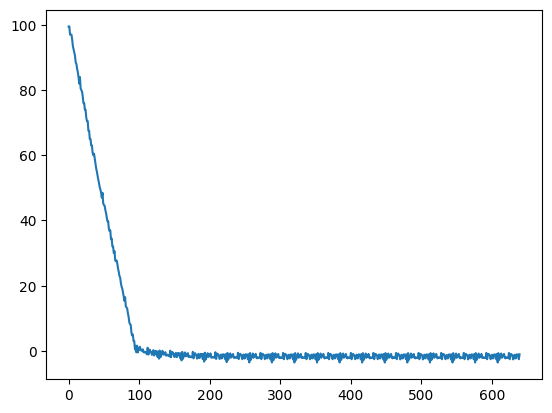

In [105]:
from matplotlib import pyplot as plt

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    # "selection/optimized_heads",
    "selection/optimized_backup_heads",
    # "selection/optimized_single_tok",
    # "selection/optimized_same_collection_single_tok",
    mt.name.split("/")[-1],
    f"{TASK_CLS.task_name}.npz"
)

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])

28


(False, False)

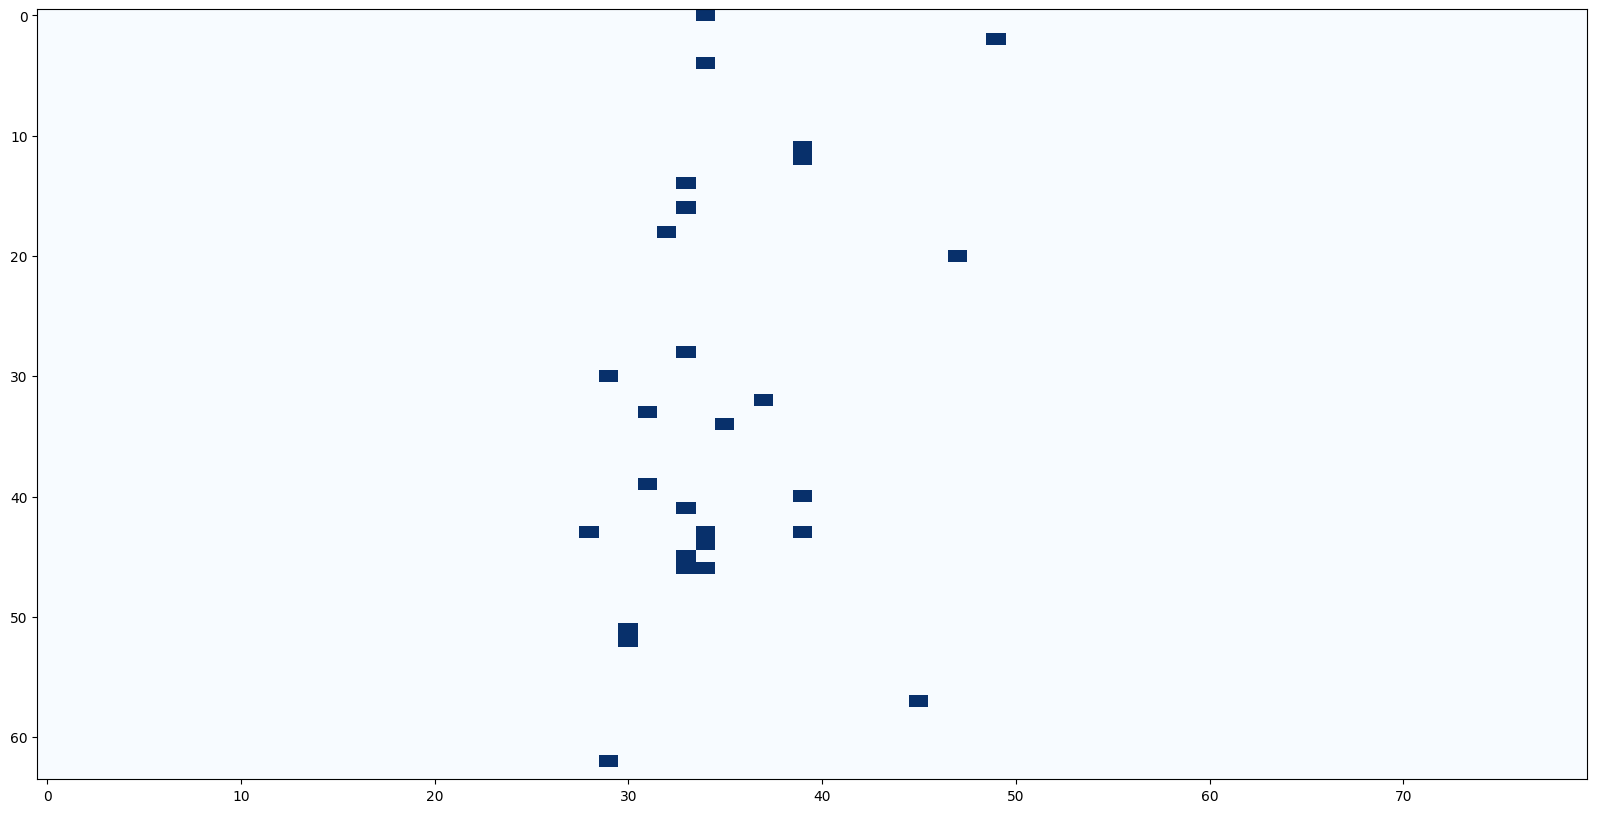

In [130]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[50:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

backup_heads = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).to(dtype=torch.int).tolist()
backup_heads = [
    (layer_idx, head_idx) for layer_idx, head_idx in backup_heads
]
print(len(backup_heads))

HEADS = backup_heads

(35, 19) in HEADS, (35, 19) in backup_heads

In [107]:
len(heads_selected), len(backup_heads)

(66, 39)

## Validation of the patching effect

In [23]:
from src.functional import free_gpu_cache
free_gpu_cache()
validation_set = []
validation_limit = 256

while len(validation_set) < validation_limit:
    patch, clean = get_counterfactual_samples_within_task(
        task=select_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=prompt_template_idx,
        option_style=OPTION_STYLE,
        n_distractors=N_DISTRACTORS,
        # distinct_options=True,
        distinct_options=False,
        shuffle_clean_options=False
    )
    validation_set.append((clean, patch))

2025-08-19 22:08:18 __main__ INFO     Patch category: office supply, subject: Marker, object: Binder
2025-08-19 22:08:18 __main__ INFO     Clean category: sport equipment, subject: Helmet, object: Football
2025-08-19 22:08:18 __main__ INFO     patch_must_have_options=['Binder', 'Football']
2025-08-19 22:08:18 __main__ INFO     clean_must_have_options=['Football', 'Binder']
2025-08-19 22:08:18 __main__ INFO     clean_type_obj='Football'
2025-08-19 22:08:18 __main__ INFO     patch_type_obj='Binder'
2025-08-19 22:08:18 __main__ INFO     patch_obj_idx=1 | ['Piano', 'Binder', 'House', 'Football', 'Strawberry', 'Iris']
2025-08-19 22:08:18 __main__ INFO     clean_obj_idx=3 | ['Piano', 'Binder', 'House', 'Football', 'Strawberry', 'Iris']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-08-19 22:08:18 __main__ INFO     Options: Piano, Binder, House, Football, Strawberry, Iris.
Which among these objects mentioned above is a office supply?
Answer:
2025-08-19 22:08:18 __main__ INFO     M

In [108]:
len(validation_set)

256

In [131]:
mt.reset_forward()
# set_attn_implementation(mt, "eager")

In [133]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair


# clean, patch = copy.deepcopy(validation_set[28])
# clean.default_option_style="numbered"
# patch.default_option_style="numbered"
# clean, patch = train_set[18]
# clean, patch = copy.deepcopy(clean_sample), copy.deepcopy(patch_sample)
# clean, patch = order_sample_2, order_sample_1
# patch, clean = order_sample_1, order_sample_2

failed_case = failed_cases[1]
clean = failed_case["clean_sample"]
patch = failed_case["patch_sample"]

print(clean.prompt(), ">>", clean.obj)
print(patch.prompt(), ">>", patch.obj)

validation_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    # heads=HEADS,
    # heads=heads_selected,
    # heads=backup_heads,
    heads=heads_selected + backup_heads,
    # heads = overlapping_heads,
    # heads=[(35, 19)],
    query_indices={-3: -3, -2: -2, -1: -1},
    verify_head_behavior_on=-1,
    # ablate_possible_ans_info_from_options=True,
    # amplification_scale=2.0
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": validation_result["clean_track"][clean_obj][0],
    "clean_logit": validation_result["clean_track"][clean_obj][1].logit,
    "target_rank": validation_result["clean_track"][target_obj][0],
    "target_logit": validation_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": validation_result["int_track"][clean_obj][0],
    "clean_logit": validation_result["int_track"][clean_obj][1].logit,
    "target_rank": validation_result["int_track"][target_obj][0],
    "target_logit": validation_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = after_intervention["clean_rank"] - before_intervention["clean_rank"]
target_rank_delta = (
    after_intervention["target_rank"] - before_intervention["target_rank"]
)
logger.info(
    f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} "
)
logger.info(
    f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} "
)

clean_logit_delta = (
    after_intervention["clean_logit"] - before_intervention["clean_logit"]
)
target_logit_delta = (
    after_intervention["target_logit"] - before_intervention["target_logit"]
)
logger.info(
    f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} "
)
logger.info(
    f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} "
)

Options: Shorts, Mirror, Bed, Basketball, Pepper, Oven.
Which among these objects mentioned above is a vegetable?
Answer: >> Pepper
Options: Shorts, Mirror, Bed, Basketball, Pepper, Oven.
Which among these objects mentioned above is a kitchen appliance?
Answer: >> Oven
2025-08-20 00:47:58 src.selection.optimization INFO     Verifying head behavior...
2025-08-20 00:47:58 src.selection.optimization INFO     Clean Sample >> Ans: Pepper


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-20 00:48:02 src.selection.functional DEBUG    Generated full answer: " Pepper.
Explanation: Pepper is a vegetable. The other options are not vegetables. Shorts are a type of clothing, a mirror is a reflective surface,"
2025-08-20 00:48:02 src.selection.functional DEBUG    Predictions: ['" Pepper"[52882] (p=0.949, logit=22.375)', '" The"[578] (p=0.017, logit=18.375)', '" Among"[22395] (p=0.005, logit=17.125)', '" A"[362] (p=0.004, logit=17.000)', '" None"[2290] (p=0.003, logit=16.750)']
2025-08-20 00:48:02 src.selection.functional INFO     Combined attention matrix for all heads


2025-08-20 00:48:02 src.selection.optimization INFO     Patch Sample >> Ans: Oven


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-20 00:48:05 src.selection.functional DEBUG    Generated full answer: " Oven. An oven is a kitchen appliance used for cooking and baking food. It is a common appliance found in most kitchens. The other options listed,"
2025-08-20 00:48:06 src.selection.functional DEBUG    Predictions: ['" Oven"[87213] (p=0.734, logit=20.750)', '" Among"[22395] (p=0.078, logit=18.500)', '" The"[578] (p=0.068, logit=18.375)', '" An"[1556] (p=0.015, logit=16.875)', '" Option"[7104] (p=0.009, logit=16.375)']
2025-08-20 00:48:06 src.selection.functional INFO     Combined attention matrix for all heads


2025-08-20 00:48:06 src.selection.optimization INFO     Caching the query states for the 94 heads
2025-08-20 00:48:06 src.selection.optimization INFO     patch_prediction=['" Oven"[87213] (p=0.734, logit=20.750)', '" Among"[22395] (p=0.078, logit=18.500)', '" The"[578] (p=0.068, logit=18.375)', '" An"[1556] (p=0.015, logit=16.875)', '" Option"[7104] (p=0.009, logit=16.375)']
2025-08-20 00:48:06 src.selection.optimization INFO     clean run
2025-08-20 00:48:06 src.selection.optimization INFO     clean_prediction=['" Pepper"[52882] (p=0.949, logit=22.375)', '" The"[578] (p=0.017, logit=18.375)', '" Among"[22395] (p=0.005, logit=17.125)', '" A"[362] (p=0.004, logit=17.000)', '" None"[2290] (p=0.003, logit=16.750)']
2025-08-20 00:48:06 src.selection.optimization INFO     clean_track=OrderedDict([(52882, (1, PredictedToken(token=' Pepper', prob=0.94921875, logit=22.375, token_id=52882, metadata=None))), (34954, (25, PredictedToken(token=' Mirror', prob=0.00020599365234375, logit=13.9375, to

2025-08-20 00:48:06 src.selection.optimization INFO     int_prediction=['" Oven"[87213] (p=0.428, logit=19.875)', '" Pepper"[52882] (p=0.379, logit=19.750)', '" The"[578] (p=0.051, logit=17.750)', '" None"[2290] (p=0.031, logit=17.250)', '" An"[1556] (p=0.017, logit=16.625)']
2025-08-20 00:48:06 src.selection.optimization INFO     int_track=OrderedDict([(87213, (1, PredictedToken(token=' Oven', prob=0.427734375, logit=19.875, token_id=87213, metadata=None))), (52882, (2, PredictedToken(token=' Pepper', prob=0.37890625, logit=19.75, token_id=52882, metadata=None))), (34954, (7, PredictedToken(token=' Mirror', prob=0.00787353515625, logit=15.875, token_id=34954, metadata=None))), (91782, (30, PredictedToken(token=' Shorts', prob=0.000881195068359375, logit=13.6875, token_id=91782, metadata=None))), (13394, (48, PredictedToken(token=' Bed', prob=0.0003662109375, logit=12.8125, token_id=13394, metadata=None))), (47589, (163, PredictedToken(token=' Basketball', prob=3.0159950256347656e-05, 

In [134]:
from tqdm.auto import tqdm

validation_results = []
for clean_sample, patch_sample in tqdm(validation_set):
    result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        # heads=heads_selected,
        # heads=backup_heads,
        heads=heads_selected + backup_heads,
        # heads = overlapping_heads,
        query_indices={-3: -3, -2: -2, -1: -1},
        verify_head_behavior_on=None,
        # amplification_scale=1.5
    )
    validation_results.append(result)
    print("=" * 80)

  0%|          | 0/256 [00:00<?, ?it/s]

2025-08-20 00:48:26 src.selection.optimization INFO     Caching the query states for the 94 heads


2025-08-20 00:48:26 src.selection.optimization INFO     patch_prediction=['" Binder"[91263] (p=0.770, logit=20.500)', '" The"[578] (p=0.081, logit=18.250)', '" A"[362] (p=0.038, logit=17.500)', '" Among"[22395] (p=0.030, logit=17.250)', '" Piano"[56491] (p=0.016, logit=16.625)']
2025-08-20 00:48:26 src.selection.optimization INFO     clean run
2025-08-20 00:48:26 src.selection.optimization INFO     clean_prediction=['" Football"[21424] (p=0.914, logit=22.000)', '" The"[578] (p=0.028, logit=18.500)', '" Among"[22395] (p=0.015, logit=17.875)', '" A"[362] (p=0.013, logit=17.750)', '" football"[9141] (p=0.004, logit=16.500)']
2025-08-20 00:48:26 src.selection.optimization INFO     clean_track=OrderedDict([(21424, (1, PredictedToken(token=' Football', prob=0.9140625, logit=22.0, token_id=21424, metadata=None))), (56491, (11, PredictedToken(token=' Piano', prob=0.00121307373046875, logit=15.375, token_id=56491, metadata=None))), (4783, (77, PredictedToken(token=' House', prob=3.4332275390625

In [135]:
before_intervention = []
after_intervention = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

In [136]:
import numpy as np

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

clean_rank_delta: 14.0195 ± 19.1826
target_rank_delta: -266.5898 ± 492.9960
clean_rank_after_intervention: 15.0234 ± 19.1801
target_rank_after_intervention: 1.1367 ± 0.5667


In [137]:
clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

clean_logit_delta: -5.5366 ± 1.9928
target_logit_delta: 9.1017 ± 2.7864
clean_logit_after_intervention: 15.7690 ± 1.9204
target_logit_after_intervention: 20.4072 ± 0.9779


In [138]:
top_1 = sum([1 for after in after_intervention if after["target_rank"] == 1])
top_1 / len(after_intervention)

0.9140625

In [139]:
counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(validation_results)})"
)

Counterfactual patching accuracy: 0.9492 (243/256)


In [100]:
for failed_case in failed_cases[:20]:
    clean_sample = failed_case["clean_sample"]
    patch_sample = failed_case["patch_sample"]
    int_track = failed_case["int_track"]
    clean_track = failed_case["clean_track"]

    print("Clean Sample:")
    print(clean_sample.prompt(), ">>", clean_sample.obj)

    print("-" * 100)
    print(
        "Track: ",
        clean_sample.metadata["track_type_obj"], " | Token"
        f"\"{mt.tokenizer.decode(clean_sample.metadata['track_type_obj_token_id'])}\"",
    )
    print("Clean:", clean_sample.obj, f"(Token: {mt.tokenizer.decode(clean_sample.ans_token_id)})")
    print("-" * 100)

    clean_track = [pred for tok_id, (rank, pred) in clean_track.items()]
    print(f"Clean Track: {json.dumps([str(pred) for pred in clean_track], indent=4)}")

    int_track = [pred for tok_id, (rank, pred) in int_track.items()]
    print(
        f"Intervened Track: {json.dumps([str(pred) for pred in int_track], indent=4)}"
    )
    print("=" * 100)

Clean Sample:
Options: Cabinet, Pear, Temple, Drum, Truck, Pine.
Which among these objects mentioned above is a tree?
Answer: >> Pine
----------------------------------------------------------------------------------------------------
Track:  Drum  | Token" Drum"
Clean: Pine (Token:  Pine)
----------------------------------------------------------------------------------------------------
Clean Track: [
    "\" Pine\"[42609] (p=0.484, logit=20.000)",
    "\" Pear\"[23910] (p=0.293, logit=19.500)",
    "\" Cabinet\"[34046] (p=0.001, logit=14.062)",
    "\" Temple\"[19176] (p=0.001, logit=13.438)",
    "\" Drum\"[46506] (p=0.000, logit=10.188)",
    "\" Truck\"[34785] (p=0.000, logit=10.188)"
]
Intervened Track: [
    "\" Pine\"[42609] (p=0.473, logit=19.625)",
    "\" Pear\"[23910] (p=0.324, logit=19.250)",
    "\" Drum\"[46506] (p=0.016, logit=16.250)",
    "\" Temple\"[19176] (p=0.009, logit=15.625)",
    "\" Cabinet\"[34046] (p=0.004, logit=14.812)",
    "\" Truck\"[34785] (p=0.000, 